In [2]:
!pip install opencv-python

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pydot graphviz


Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install geocoder requests pandas twilio geopy


In [6]:

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import geocoder
import requests
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim

# Setting up our Data  
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [7]:
batch_size = 100
img_height = 250
img_width = 250

The dataset that we are using has 3 different folders, and each of these have 2 folders within them having a folder for accident images and non accident images. Do look and scroll through them to verify and see the structure.  
In order to get our:  
1. train,
2. test
3. and validation split,  

we will use keras's inbuilt *image_dataset_from_directory()* function which is able to generate a tf dataset containing the images as well as their corresponding classes from the folder that we pass into the parameter.

In [8]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\ayush\Desktop\New folder\data\train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\ayush\Desktop\New folder\data\test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\ayush\Desktop\New folder\data\val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [9]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Defining our Pre-Trained Model  
The next step is defining and creating our model. In order to increase accuracy and speed up training process, we'll go ahead and use a pre trained model for this task. Why you may ask?  This is because a pretrained convnet already has a very good idea of what features to look for in an image and can find them very effectively since it hs been trained on millions of images. So, if we can determine the presence of features all the rest of the model needs to do is determine which combination of features makes a specific image.  
So all we've to do is:
1. Define the base pretrained layer
2. Add final few layers that are specific to our function and task to enhance ability in those categories
3. Train our model!  
Lets use Googles MobileNetV2 for this purpose...


In [10]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

C:\Users\ayush\AppData\Local\Temp\ipykernel_2008\451698701.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,


Notice how we set trainable to false in order to make sure model won’t make any changes to the weights of any layers that are already frozen during training.  
We also exclude the top of the model since we will perform classification on our own.

# Creating Final Model  
We now go ahead and create our final model which consists of the base model, and 3 more layers for performing convolution. The 2d output of the convolution layer is flattened and fed to a dense output layer to perform the classification. 

In [11]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

In [12]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We'll let our model run for 50 epochs, which seems like a decent enough number. Increasing the epochs should result in an increase in accuracy uptil a certain point only though...

In [13]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 20)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4925 - loss: 0.9611 - val_accuracy: 0.7041 - val_loss: 0.6348
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7099 - loss: 0.6026 - val_accuracy: 0.8163 - val_loss: 0.5171
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8276 - loss: 0.4407 - val_accuracy: 0.8469 - val_loss: 0.3928
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8796 - loss: 0.2804 - val_accuracy: 0.8878 - val_loss: 0.2772
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9382 - loss: 0.1567 - val_accuracy: 0.8673 - val_loss: 0.3208
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9710 - loss: 0.0966 - val_accuracy: 0.9490 - val_loss: 0.1552
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9849 - loss: 0.0489 - val_accuracy: 0.9592 - val_loss: 0.0988
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9854 - loss: 0.0364 - val_accuracy: 0.8878 - val_loss: 0.2823
Epoch 9/

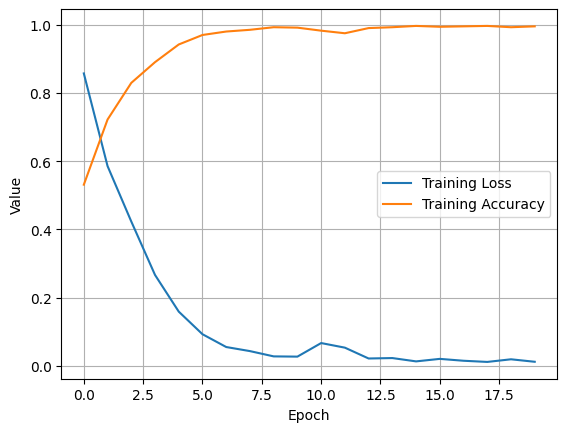

In [14]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


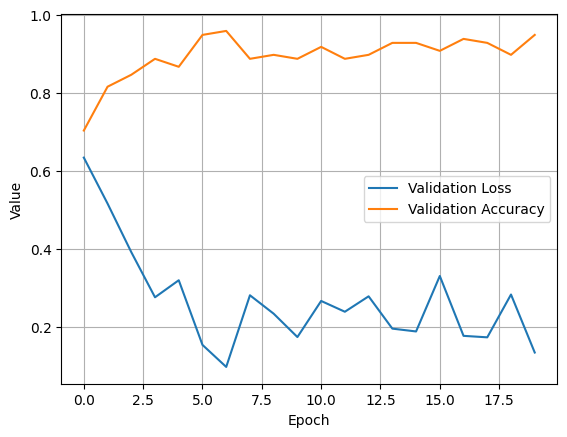

In [15]:


plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


The function below looks a bit complicated, but is a simple helper function which shows the image, the predicted class and the actual class for each image in the test dataset. Run it and have a look at how accurate the model seems and where it seems to be struggling.

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step


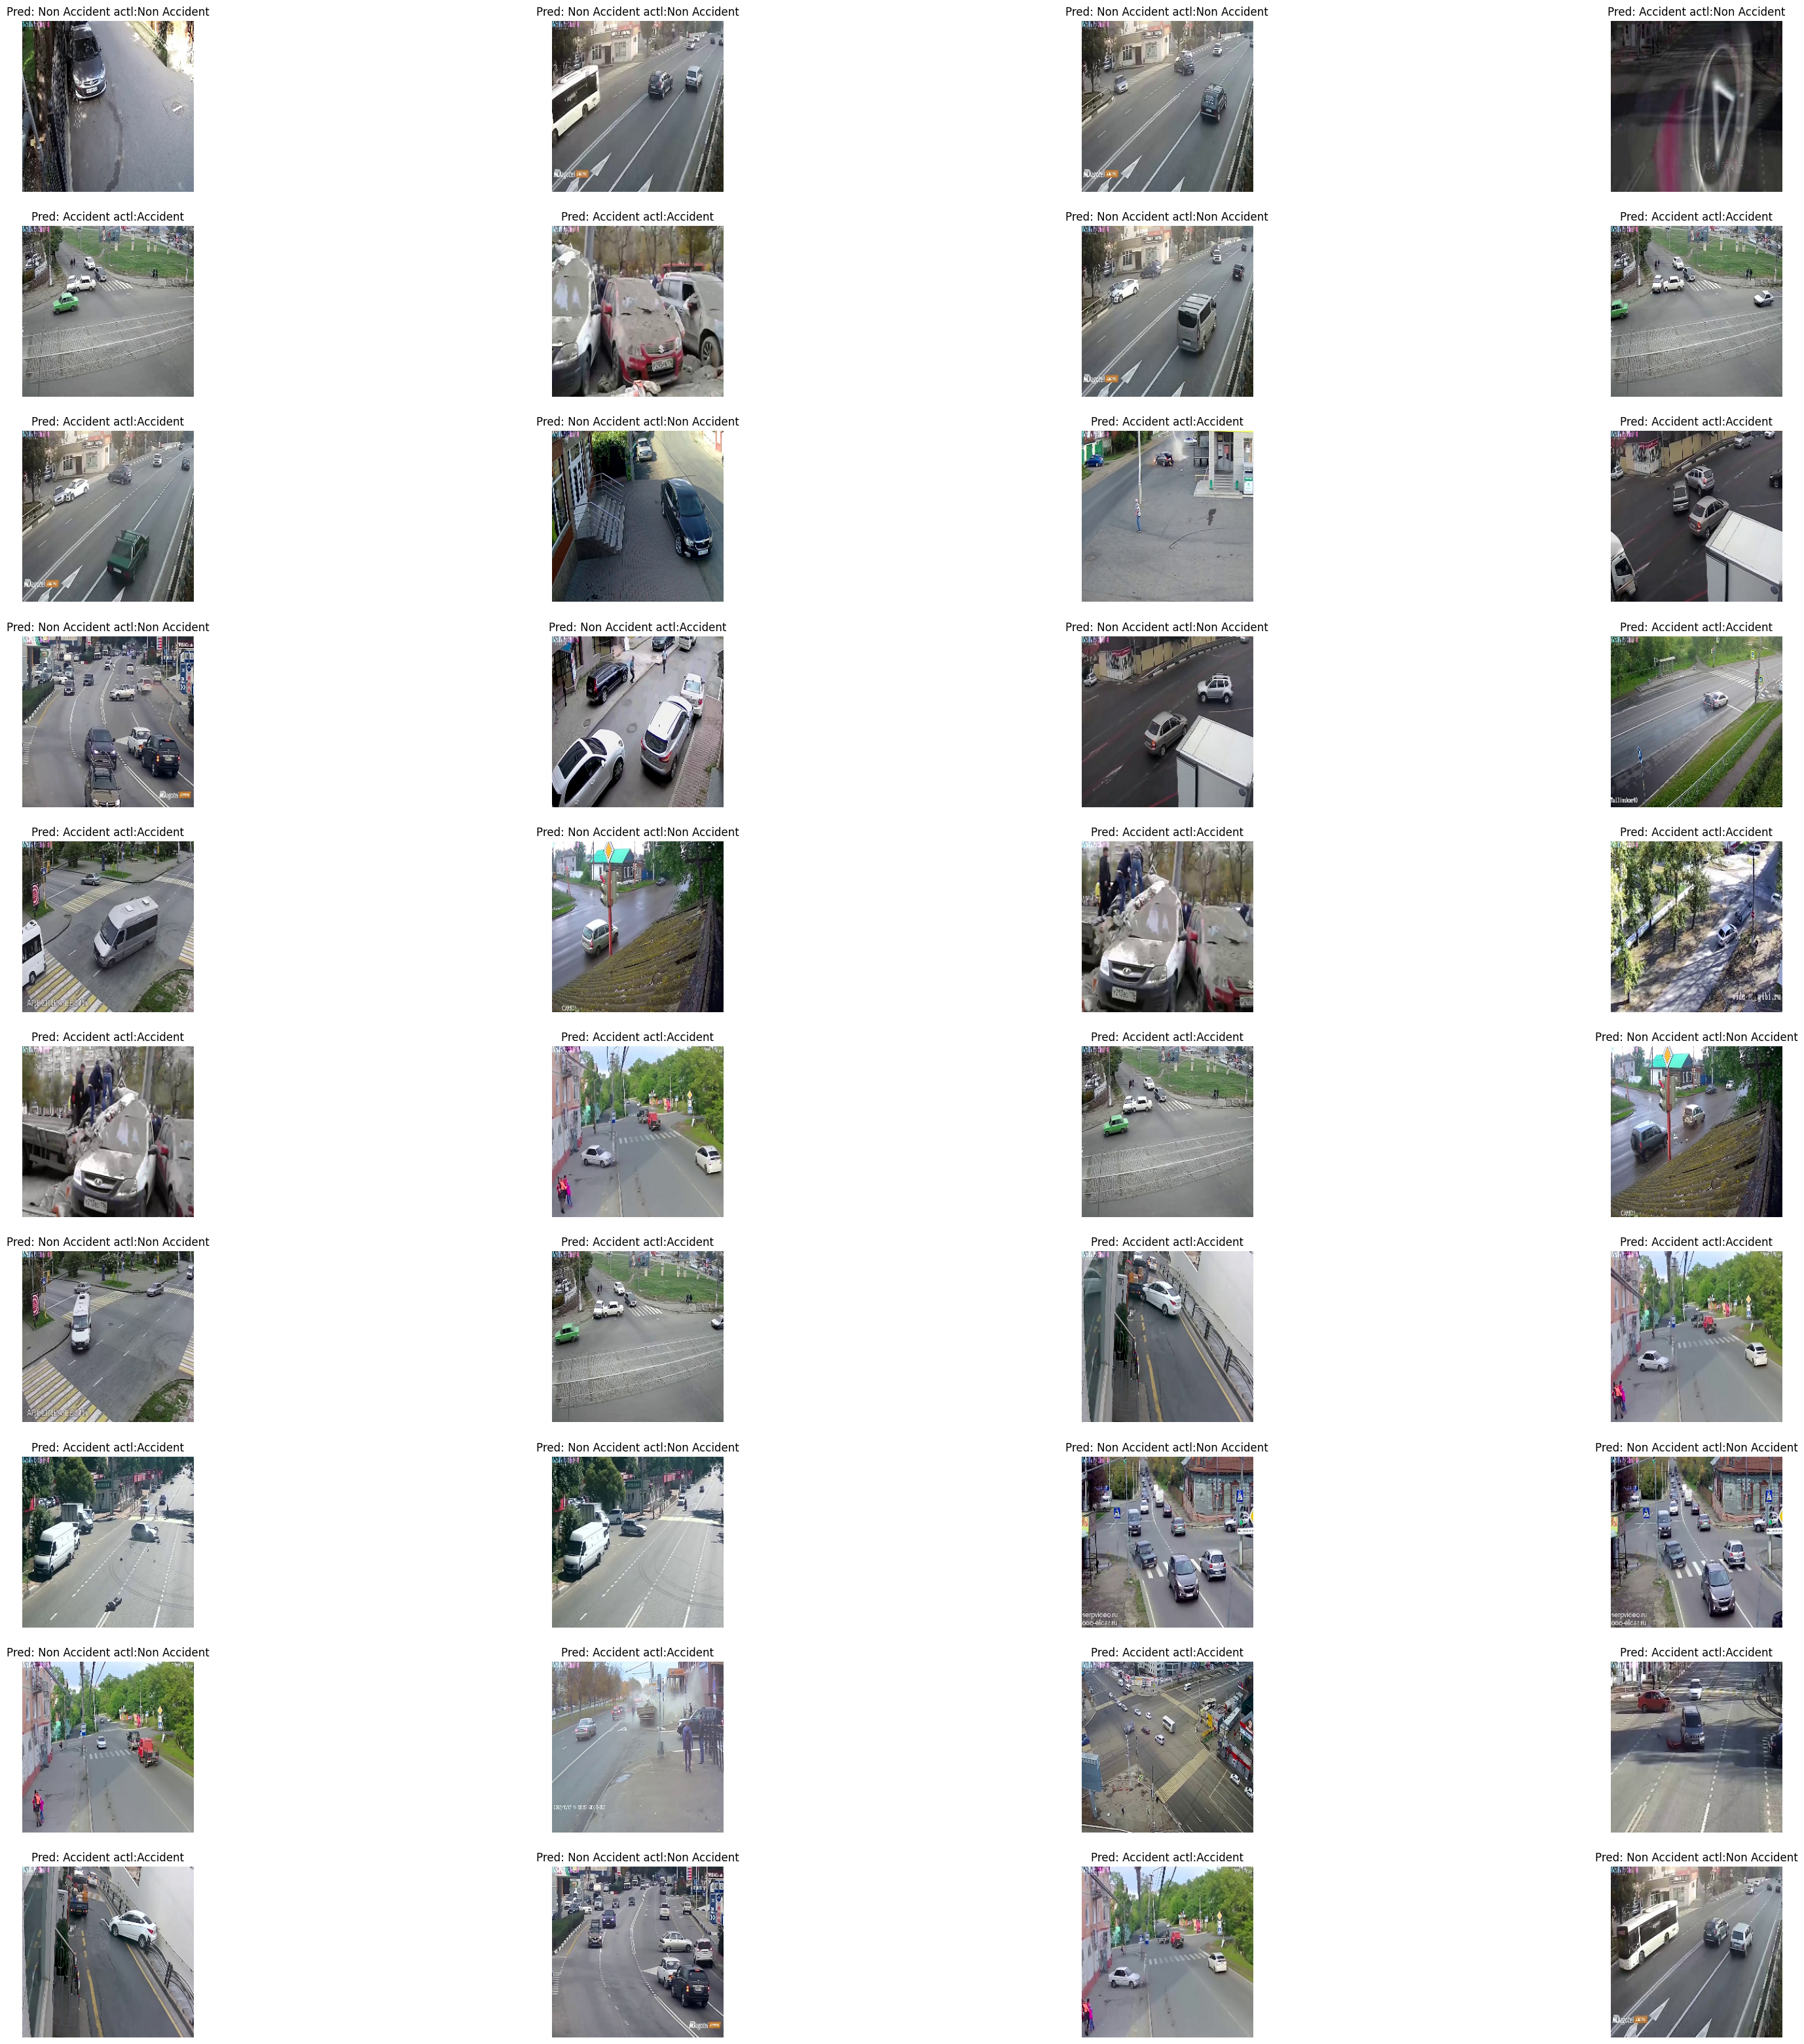

In [16]:
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [17]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive event is accident negative event is non accident
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [18]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 43
True negatives are: 51
False negatives are: 4
False positives are: 2


We can go ahead and view the models layers through the plot_model function below provided by keras for an intuitive view.

And thats all! We've successfully creating a model with an accuracy of around 90%. Notice that this can be further improved by performing image manipulation, performing pooling and training our model for a longer epoch or even adding more layers.. However, for our use case, this model we created is perfectly fine.  

In [19]:
print(class_names)

['Accident', 'Non Accident']


# Testing Model on Videos  
In order to use our model on a video, which is our expected use case of a CCTV footage, we will have to use OpenCV in order get the individual frames.  
Lets define a function which takes in each frame and converts it into a tensor and then predicts the output class.

In [20]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")
    

The following code below makes use of OpenCV. Firstly, we read the video in and grab every 20th frame(in order to reduce total computation for this demonstration) and then we can resize the image and run our function on it.  
We'll store the label and the image in a list which we can easily access.

In [32]:
import cv2
import numpy as np
import tensorflow as tf

font = cv2.FONT_HERSHEY_SIMPLEX

def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_batch)
    prob = prediction[0][0]  # Assuming model output is in the form [[0.85]]
    if prob > 0.1:
        return "No Accident"
    else:
        return "Accident Detected"

cap = cv2.VideoCapture(r'C:\Users\ayush\Desktop\New folder\istockphoto-684764514-640_adpp_is.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (250, 250))
    prediction = predict_frame(resized_frame)
    #print("Prediction:", prediction)  # Debug print to verify predictions

    # Drawing a rectangle and put text based on prediction
    cv2.rectangle(frame, (0, 0), (300, 40), (0, 0, 0), -1)  # Background for text
    cv2.putText(frame, prediction, (20, 30), font, 1, (255, 255, 0), 2)

    cv2.imshow('Video', frame)

    if cv2.waitKey(33) & 0xFF == ord('q'):
        break
print("Prediction:", prediction)
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

Lets see any random frame and see what the outcome is...

In [ ]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid ="" #Enter Your account sid
auth_token = ""#Enter your auth token
client = Client(account_sid, auth_token)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=12.2266&lon=79.0746&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [ ]:

flag = 0
if prediction == "Accident Detected":
    flag = 1

if flag == 1:
    client.messages.create(
        body="Accident detected at " + locname.address,
        from_="",  # Enter your virtual phone number
        to=""  # Enter phone number to which you want to send the SMS
    )




In [25]:
print(prediction)

Accident Detected


Looks about right! There seems to be an accident occuring in this frame. Our model generalizes well and can be used for practical applications.

# Converting to TFLite Model  
While we've made our model, it is true that Tensor Flow models are very large and bulky and not suitable for the small processing powers that a CCTV surveillance system will handle. For this purpose, we'll convert our Tf model into a TFLite model through the API's available by keras.

In [29]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('tf_lite_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ayush\AppData\Local\Temp\tmpai26yokx\assets


INFO:tensorflow:Assets written to: C:\Users\ayush\AppData\Local\Temp\tmpai26yokx\assets


Saved artifact at 'C:\Users\ayush\AppData\Local\Temp\tmpai26yokx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2025103563792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104855248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104854096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104855632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104855824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104855056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104853904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104854864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104856016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2025104856592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

A TFLite model is referred to as an interpreter. We open it up and have a look at the input and output shape. It should be a single image of height and width 250 by 250 with 3 colour channels.  
The output can be of 2 types only. Accident or Non Accident.

In [30]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


While the steps below aren't necessary, I'll still show you incase you have to perform a similair task for a different model where the input tensor might change or be different.

In [31]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 250, 250,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


# Trying Our TFLite Model Out  
We'll try our TFLite model on a random image and see what our output is and if it works. 

In [33]:
from PIL import Image
im=Image.open(r"C:\Users\ayush\Desktop\New folder\data\train\Non Accident\5_6.jpg").resize((250,250))
img_array = tf.keras.utils.img_to_array(im)
img_batch = np.expand_dims(img_array, axis=0)

The below lines are equivalent to performing a prediction in a TF model. *interpretor.get_tensor(*) performs the prediction.

Prediction results: 0.99879766
Accident Detected
AxesImage(shape=(250, 250, 3))


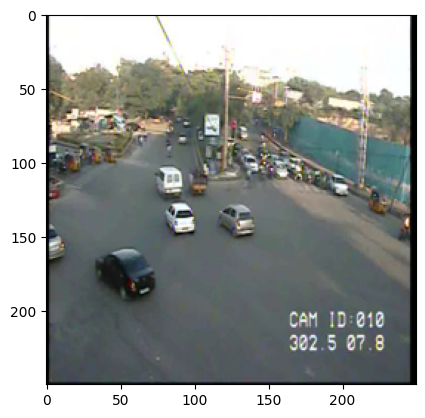

In [34]:
interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", tflite_model_predictions[0][1])
print(prediction)
print(plt.imshow(im))

It works. We've got a complete end to end system for accident detection now that should work very well indeed even for surveillance camera.